<a href="https://colab.research.google.com/github/devloper13/SiameseNetworkProject/blob/master/Copy_of_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network Code 

The following modules in python has been used 
<ul>
  <li>Tensorflow for constructing Siamese Networks</li>
  <li>NLTK library for stemming and stop words removal</li>
  <li>Google Drive library for data strage</li>
  <li>Scikit, Numpy and Pandas for misc. tensor computations</li>
<ul>
  

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from builtins import input

#import system things
from tensorflow.examples.tutorials.mnist import input_data # for data
import tensorflow as tf
import numpy as np
import os
import keras


# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
import tensorflow as tf
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import pickle
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
import nltk
nltk.download('stopwords')

nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Siamese Network Implementaiton

Implementation is mostly done using barebones tensorflow with tensor variables, placeholders and constants . No predefined library was used in this implementation. The structure below is not a generic siamese network but can be made one by generalizing a few parameters.

In [0]:
idim = 30628

class Siamese:

    # Create model
    def __init__(self,dname="Siamese"):
        self.x1 = tf.placeholder(tf.float32, [None, idim])
        self.x2 = tf.placeholder(tf.float32, [None, idim])

        with tf.variable_scope(dname) as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)

        # Create loss
        self.y_ = tf.placeholder(tf.float32, [None])
        #self.y_ = tf.placeholder(tf.int32, [None])
        self.loss = self.cosineLoss()

    #create the network 
    def network(self, x):
        
        x = tf.reshape(x,shape=[-1,1,idim,1])
        activated_conv1 = self.conv_layer('conv_1',x,3)
        maxpool1 = self.maxpool_layer('maxp_1',activated_conv1)
        
        flattened_conv = tf.layers.flatten(maxpool1)   #To be removed
        activated_fc1 = self.fc_layer( "fc1",flattened_conv, 128)
        #activated_fc2 = self.fc_layer("fc2",activated_fc1, 1024)
        #activated_fc3 = self.fc_layer("fc3",activated_fc2, 2)
        
        return activated_fc1
        
    #create the convolution layer 
    def conv_layer(self,name,inputs,cur_channel):
        #print(inputs.get_shape())
        prev_channel = inputs.get_shape()[-1]
        #print(prev_channel)
        init = tf.variance_scaling_initializer(scale=2.0)
        w = tf.get_variable(name+"_w",dtype=tf.float32,shape=[1,10,prev_channel,cur_channel],initializer=init)
        b = tf.get_variable(name+"_b",dtype=tf.float32,shape=[cur_channel],initializer = init)
        conv = tf.nn.conv2d(inputs,w,strides=[1,1,1,1],padding = "SAME")
        activation = conv+b
        return activation  
      
    def maxpool_layer(self,name,inputs):
        return tf.nn.relu(tf.nn.max_pool(inputs,ksize=[1,1,100,1],strides=[1,1,100,1],padding="SAME"))  
    
    def fc_layer(self,name,inputs,cur_layer):
        print(inputs.get_shape())
        prev_layer = inputs.get_shape()[-1]
        init = tf.truncated_normal_initializer(stddev=0.01)
        w = tf.get_variable(name+"_w",dtype=tf.float32,shape=[prev_layer,cur_layer],initializer=init)
        b = tf.get_variable(name+"_b",dtype=tf.float32,shape=[cur_layer],initializer=init)
        activation = tf.matmul(inputs,w)+b
        return activation
    
        
    def cosineLoss(self):
        
        norms1 = tf.norm(self.o1,axis=1)
        norms2 = tf.norm(self.o2,axis=1)
        norm = tf.multiply(norms1,norms2)
        cosines = tf.div(tf.reduce_sum(tf.multiply(self.o1,self.o2),axis=1),norm)
        
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        
        
        C = tf.constant(0.5, name="C")
        
        pos = tf.multiply(labels_t,tf.subtract(1.0,cosines), name="yi_x_cosine")
        
        neg = tf.multiply(labels_f, tf.maximum(tf.subtract(cosines,C),0), name="Nyi_x_C-cosine")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
        

          

### Get Pickled Dictionary stored in Drive


In [0]:
link="https://drive.google.com/open?id=1Jhj9OazxPnvLcuuZsZvNFfpnnsFg88I7"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('three_hash')  
with open('three_hash','rb') as f:
   three_hash_dict = pickle.load(f)
print(len(three_hash_dict))

30628


### Three hash generation function

This function takes the text and tokenizes it, performs steming and stop words removal using NLTK. 

In [0]:
stop_words = set(stopwords.words('english')) 
def getThreeHash(text):
  vectorizer = CountVectorizer()
  tokenizer=vectorizer.build_tokenizer()
  
  hashes=""
  tokens=tokenizer(text)
  ps = PorterStemmer()
  tokens = [ps.stem(word) for word in tokens]
  for token in tokens:
    if token not in stop_words:
      tokenModi="#"+token+"#"
      output = list(ngrams(tokenModi, 3))
      for a in output:
        hashes+=(''.join(a))+" "
  
  return(hashes)


### Get Data Set

In [0]:
link="https://drive.google.com/open?id=17VMN5CJA05vTPEs15gw-W2ocxmEITQEH" #create shareable link of google drive file
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('QA.csv')  
ndata = pd.read_csv('QA.csv',error_bad_lines=False).values


17VMN5CJA05vTPEs15gw-W2ocxmEITQEH


### Take only a subset as training

In [0]:
data = ndata[:15000,1:]

### Cosine Distance SImilarity 

This is done so that systactically similar questions are taken into consideration. The distance metric used is a cosine distance on simple word hashed representation of texts.

In [0]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokenlower = [word.lower() for word in tokens]
    
    stopWords = set(stopwords.words('english'))
    tokenlower = [word for word in stopWords if word not in stopWords]
    
    tokenDict = nltk.defaultdict(int)
    for word in tokens:
        tokenDict[word] += 1
    return tokenDict

def cosDistance(v1,v2):
    dotProduct = np.dot(v1,v2)
    normV1 = np.linalg.norm(v1)
    normV2 = np.linalg.norm(v2)
#     print(dotProduct,normV1,normV2)
    return dotProduct / (normV1 * normV2)

def getSimilarity(vDict1,vDict2):
    allWords = []
    for key in vDict1:
        allWords.append(key)
    for key in vDict2:
        allWords.append(key)
    allWordsSize = len(allWords)
    
    v1 = np.zeros(allWordsSize,dtype=np.int)
    v2 = np.zeros(allWordsSize,dtype=np.int)
    
    i = 0
    for key in allWords:
#         print(key)
        v1[i] = vDict1.get(key, 0)
        v2[i] = vDict2.get(key, 0)
        i += 1
#     print(v1,v2)    
    return cosDistance(v1,v2)

### Batch Creation and vectorization of text

In [0]:
def vectorize(hashString,dictionary):
  
  vectorizer = CountVectorizer()
  tokenizer = vectorizer.build_tokenizer()
  vec = [0]*idim
  
  for token in tokenizer(hashString):
    try:
      vec[dictionary[token]] += 1
    except:
      pass
    
  return vec

def createBatch(data,goodSet,badSetQues,badSetAns,dictionary):
  
  good_data = data[goodSet]
  bad_quest = data[badSetQues,0]
  bad_anser = data[badSetAns,1]
  questions = np.concatenate((good_data[:,0],bad_quest))
  answers = np.concatenate((good_data[:,1],bad_anser))
  label = np.array([1]*good_data.shape[0] + [0]*bad_quest.shape[0])
  
  ques,ans = [],[]
  for d in questions:
    ques += [vectorize(getThreeHash(d.lower()),dictionary)]
  for i,d in enumerate(answers):
    ans += [vectorize(getThreeHash(str(d).lower()),dictionary)]
  return np.array(ques),np.array(ans),label
    
def getRandomBatch(data,batchsize,dictionary,good_bad=0.5):
  
  goodSet = np.random.permutation(data.shape[0])[:int(batchsize*good_bad)]
  badSetQues = np.random.permutation(data.shape[0])[:batchsize - int(batchsize*good_bad)]
  badSetAns = np.random.permutation(data.shape[0])[:batchsize - int(batchsize*good_bad)]
  return createBatch(data,goodSet,badSetQues,badSetAns,dictionary)
  

    

### Initializing Siamese networks and optimizer

In [0]:
tf.reset_default_graph()
siamese = Siamese('siamese6')
try:
  sess.close()
except:
  pass
sess = tf.InteractiveSession()
train_Step = tf.train.MomentumOptimizer(0.01,0.05).minimize(siamese.loss)
tf.initialize_all_variables().run()

(?, 921)
(?, 921)


### Training with siamese Networs

In [0]:
def trainSiameseNetwork(data,siamese,sess,batchSize,epochs,dictionary):
  
  #Siamese Network
  #sess = tf.Session()
  #tf.reset_default_graph()
  #siamese = Siamese()
  
  while epochs > 0:
    
    avg = 0.0
    permSet = np.random.permutation(data.shape[0])

    for p in range(0,permSet.shape[0],batchSize):

      goodSet = np.array(list(range(p,p+batchSize)))
      badSetQ = goodSet.copy()
      badSetA = np.array(permSet[p:p+batchSize])
      ques,ans,labl = createBatch(data,goodSet,badSetQ,badSetA,dictionary)


      #print(ques.shape,ans.shape,labl.shape)
      _, Loss = sess.run([train_Step,siamese.loss], feed_dict={
                    siamese.x1: ques,
                    siamese.x2: ans,
                    siamese.y_: labl})
      avg += Loss
      #print("Epoch",epochs,"Batch",p/batchSize,"Loss",Loss)
    
    print("Average Epoch ",epochs,"Loss ",avg/(data.shape[0]/batchSize))
    epochs -= 1
        

In [0]:
def predict(qset,ques,siamese,sess,dictionary,alpha=0.5,best=3):
  
  vques  = preprocess(ques)
  thQues = np.array(vectorize(getThreeHash(ques.lower()),dictionary)).reshape(1,-1)

  scores = []

  for q in qset:

    oQues = np.array(vectorize(getThreeHash(str(q).lower()),dictionary)).reshape(1,-1)
    vQues = preprocess(q)
    Loss = sess.run([siamese.loss],feed_dict={
                    siamese.x1: thQues,
                    siamese.x2: oQues,
                    siamese.y_: np.array([1.0])})
    tLoss = getSimilarity(vques,vQues)
    #print(alpha*Loss[0],(1-alpha)*(1-tLoss))
    scores += [alpha*Loss[0] + (1-alpha)*(1-tLoss)]

  sscores = np.argsort(np.array(scores))[:best]
  return qset[sscores],scores
  

## Training With Data

In [0]:

trainSiameseNetwork(data,siamese,sess,100,30,three_hash_dict)

Average Epoch  30 Loss  0.2212472610672315
Average Epoch  29 Loss  0.21664690911769868
Average Epoch  28 Loss  0.2160269269347191
Average Epoch  27 Loss  0.21272770444552103
Average Epoch  26 Loss  0.20940782397985458
Average Epoch  25 Loss  0.20769936154286067
Average Epoch  24 Loss  0.20592495193084082
Average Epoch  23 Loss  0.20417876342932384
Average Epoch  22 Loss  0.20203619917233784
Average Epoch  21 Loss  0.2002578624089559
Average Epoch  20 Loss  0.20013174811999004
Average Epoch  19 Loss  0.19932048112154008
Average Epoch  18 Loss  0.19849730849266053
Average Epoch  17 Loss  0.19728544632593792
Average Epoch  16 Loss  0.19571996241807937
Average Epoch  15 Loss  0.19578041245539984
Average Epoch  14 Loss  0.19457765718301137
Average Epoch  13 Loss  0.19408452729384104
Average Epoch  12 Loss  0.19323520402113598
Average Epoch  11 Loss  0.19292492896318436
Average Epoch  10 Loss  0.19209618578354518
Average Epoch  9 Loss  0.19146901975075403
Average Epoch  8 Loss  0.19107891132

In [0]:
trainQues = ndata[:20000,1]

## Some Results

In [0]:
gtp = 3
def MAPScore(arr):
  
  sumx,tsum = 0,0
  for i,t in enumerate(arr):
    sumx += t
    tsum += (sumx * t)/(i+1)
  print("MAP SCORE ",min(tsum,gtp)/gtp)
  return tsum/gtp

In [0]:
 ques = input("Enter a question - ")  #1
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.9,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - How to attract a girl?
Best Three Answers 
how i can atract a girl?
How to ask a girl to hang out with me?
how to attract women ?
Anyone think peircings are attractive? If so where at and why?
does anyone out there think big girls are attractive?
with a girl have nothing?


In [0]:
labels = [1,1,0,0,0,1]
_ = MAPScore(labels)

MAP SCORE  0.6666666666666666


In [0]:
ques = input("Enter a question - ")  #2
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.8,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - What is best place to eat?
Best Three Answers 
What is the best place to eat in Las Vegas?
Whats a good place to eat in LA?
Where is the best place to eat Mexican food?
What is the best place to party in SF?
Where is the best place to teach in the USA?
Where is the hottest place on earth?


In [0]:
labels = [1,1,1,0,0,1]
_ = MAPScore(labels)

MAP SCORE  1.0


In [0]:
ques = input("Enter a question - ")  #3
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - what is the best internet site?
Best Three Answers 
what is the best dating site?
what is the best news site on the net?
what is internet?
what is internet 2?
what is the best site for people who are board on the internet?
What is the internet missing?


In [0]:
labels = [1,1,0,0,0,0]
_ = MAPScore(labels)

MAP SCORE  0.6666666666666666


In [0]:
ques = input("Enter a question - ")   #4
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.9,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - How can I become naturally happy?
Best Three Answers 
Are you happy?
What is happiness?
What is happiness?
what's happiness?
Is Apple Aperture any good?
What makes you happy?


In [0]:
labels = [1,0,1,1,1,0]
_ = MAPScore(labels)

MAP SCORE  1.0


In [0]:
ques = input("Enter a question - ")  #5
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.8,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - Do you need to go to university to work in a nursery or pre-school?
Best Three Answers 
do you go to public of private school? dont tell me what school you go to.?
why go to school?
What college should I look into if I wanted to go to school to be an attorney?
How to choose a good telescope to buy?
What is the best film school to go to if I want to become a director?
i need to rent a home?


In [0]:
labels = [0,0,0,0,0,0]
_ = MAPScore(labels)

MAP SCORE  0.0


In [0]:
ques = input("Enter a question - ")  #6
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - Who is most famous celebrity?
Best Three Answers 
Who is the most famous hacker?
Who is the most famous woman athlete of all time?
Who is the most famous woman in human history?
Who is the most famous orator in the history?
Who is Eddie Van Halen?
What is the most famous breed of horse?


In [0]:
labels = [1,1,1,1,1,0]
_ = MAPScore(labels)

MAP SCORE  1.0


In [0]:
ques = input("Enter a question - ")  #7
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - Does smoking affect an unborn child?
Best Three Answers 
How many people do you know that died from smoking ?(not side effects of smoking but from smoking)?
how do i stop smoking?
what diseases come from smoking?
Is smoking cigarettes near children a form of child abuse?
Is smoking marijuana any better than drinking alcohol  or smoking cigarettes?
What is an orgasm?


In [0]:
labels = [1,0,1,1,0,0]
_ = MAPScore(labels)

MAP SCORE  0.8055555555555555


In [0]:
ques = input("Enter a question - ")   #8
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - What best way to publish a book?
Best Three Answers 
What's the best way to approach a publisher with a non-fiction text book?
What is the best way to sell an eBook?
What is the best(cheapest) way to book a cruise if you want to book a certain area  time  and class of cabin?
What's the best way to clean a keyboard?
What are the steps required to edit  publish and distribute a book?
how do you get a book published?


In [0]:
labels = [1,0,0,0,1,1]
_ = MAPScore(labels)

MAP SCORE  0.6333333333333333


In [0]:
ques = input("Enter a question - ")   #9
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - How do I put a video on YouTube?
Best Three Answers 
How do I find the specs on my video card?
How do I recover a video file on my hard drive that I have overwritten?
How do you put on a condom?
How can I find the dhcp server on Linux ?
What do I do?
What should I do?


In [0]:
ques = input("Enter a question - ")  #10
score = predict(trainQues,ques,siamese,sess,three_hash_dict,alpha=0.5,best = 6)
print("Best Three Answers \n%s\n%s\n%s\n%s\n%s\n%s" % (score[0][0],score[0][1],score[0][2],score[0][3],score[0][4],score[0][5]))

Enter a question - What are the advantages of Facebook?
Best Three Answers 
what are the advantages of antibacterial products?
Facebook or MySpace?
What is the advantage of a 529 plan for college savings?
what are the colors in rainbow?
what is rebate?and what the advantage?
Where's the best place to buy discounted Colorado lift tickets (Breck  Vail)?  I live out of state.?


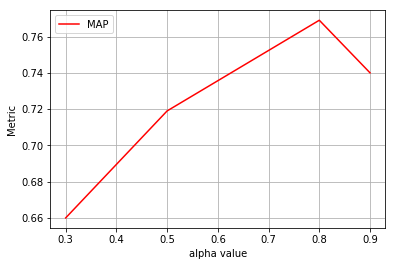

In [1]:
import matplotlib.pyplot as plt
plt.plot([0.9,0.8,0.5,0.3],[0.74,0.769,0.719,0.66],color = 'r',label = "MAP")
# plt.plot([0.9,0.8,0.5,0.3],[0.86,0.875,0.781,0.7],color = 'b',label = "MRR")
plt.xlabel('alpha value')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()    
